# Основная программа

In [1]:
# !pip install pyts

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import (
    check_array, check_is_fitted, check_random_state)

%matplotlib inline
warnings.filterwarnings('ignore')

In [18]:
def whiteNoise(sigma=1, size=1):
    return np.random.normal(0, sigma, size)

def split_on_windows(X,len_w,len_k,step=1):
    if step>len_w:
        raise TypeError("Шаг должен быть меньше, либо равен размеру окна {} > {}".format(step,len_w))
    n = len(X)
    count_w_k = n-len_k-len_w+1
    split_data_windows = []
    split_data_future = []
    
    if type(X) == type(list()):
        X = np.array(X)
    
    if len(X.shape) == 1:
        X_copy = []
        for val in X:
            X_copy.append([val])
        X = np.array(X_copy)
    
    for i in range(0,count_w_k,step):
        split_data_windows.append(X[i:i+len_w])
        split_data_future.append(X[i+len_w:i+len_w+len_k])
        
    split_data_windows = np.array(split_data_windows)
    split_data_future = np.array(split_data_future)
    if len(split_data_windows.shape) == 2:
        return split_data_windows[:,0], split_data_future[:,0]
    elif len(split_data_windows.shape) == 3:
        return split_data_windows[:,:,0], split_data_future[:,:,0]

def get_coefs_linear_regression(values): 
    coefs = []
    size_future_window = len(values[0])

    X = np.array([[i+1] for i in range(size_future_window)])

    for i in range(len(values)):
        y = values[i]
        reg = LinearRegression().fit(X,y)
        coefs.append(reg.coef_)
    coefs = np.array(coefs)
    return coefs

def extract_mean_std_slope(X):
    '''
    This transformer extracts 3 features from each window: the mean, the
    standard deviation and the slope.
    '''
    n_windows = X.shape[0]
    X_new = np.empty((n_windows, 3))
    start = 0
    end = X.shape[1]
    arange = np.arange((start - end + 1) / 2, (end + 1 - start) / 2)
    if end - start == 1:
        var_arange = 1.
    else:
        var_arange = np.sum(arange ** 2)

    for i in range(n_windows):    
        mean = np.mean(X[i])
        X_new[i, 0] = mean
        X_new[i, 1] = np.std(X[i])
        X_new[i, 2] = (
            np.sum((X[i] - mean) * arange) / var_arange
        )
    return X_new

def extract_rocket(X,n_kernels=100,random_state=None):
    from pyts.transformation import ROCKET

    X_rocket = X
    rocket = ROCKET(n_kernels=n_kernels,random_state=random_state)
    rocket.fit(X_rocket)
    return rocket.transform(X)

In [19]:
class GetClasses(BaseEstimator):
    '''
    method: str (default = "growth")
        'growth':
        'type':
        (Описание).
    percent: int (default = 10)
        (Описание).
    random_state: int or None (default = None)
        (Описание).
    '''
    def __init__(self,
                 method='growth',
                 percent=20,
                 random_state=None
                ):
        self.percent = percent
        self.method = method
        self.random_state = random_state
    
    def get_parameters(self):
        self.coefs_pos = self.coefs[np.where(self.coefs>=0)]
        self.coefs_neg = self.coefs[np.where(self.coefs<0)]
        
        self.check_pos = np.max(self.coefs_pos) / 100 * self.percent
        self.check_neg = np.min(self.coefs_neg) / 100 * self.percent

        # обработка положительного тренда
        self.max_coef_pos = np.max(self.coefs_pos)
        self.min_coef_pos = np.min(self.coefs_pos)
        self.distance_pos = (self.max_coef_pos + self.min_coef_pos)
        self.middle_pos = self.distance_pos / 2
        self.up_limit_pos = self.distance_pos / 100 * (50 + self.percent/2) # верхняя граница, больше относительно середины на (percent/2)%
        self.down_limit_pos = self.distance_pos / 100 * (50 - self.percent/2) # нижняя граница, меньше относительно середины на (percent/2)%

        # обработка отрицательного тренда
        self.max_coef_neg = np.max(self.coefs_neg)
        self.min_coef_neg = np.min(self.coefs_neg)
        self.distance_neg = (self.max_coef_neg + self.min_coef_neg)
        self.middle_neg = self.distance_neg / 2
        self.up_limit_neg = self.distance_neg / 100 * (50 + self.percent/2) # верхняя граница, больше относительно середины на (percent/2)%
        self.down_limit_neg = self.distance_neg / 100 * (50 - self.percent/2) # нижняя граница, меньше относительно середины на (percent/2)%
        return self
    
    def get_classes_type(self): 
        '''
        класс "1" - положительный тренд
        класс "0" - тренд отсутствует
        класс "-1" - отрицательный тренд
        '''
        
        classes = []
        for val in self.coefs:
            if val > self.check_pos : classes.append(1)
            elif val < self.check_neg : classes.append(-1)
            else: 
                classes.append(0)
        classes = np.array(classes)
        return classes
    
    def get_classes_growth(self):
        '''
        proc - количество элементов в процентах, относящихся к классу "0"
        класс "1" - сильный рост тренда
        класс "0" - средний рост тренда
        класс "-1" - слабый рост тренда
        '''
        
        classes = []
        for val in self.coefs:
            if val >= 0:
                if val > self.up_limit_pos : classes.append(1)
                elif val < self.down_limit_pos : classes.append(-1)
                else: 
                    classes.append(0)
            else:
                if val < self.up_limit_neg : classes.append(1)
                elif val > self.down_limit_neg : classes.append(-1)
                else: 
                    classes.append(0)
        classes = np.array(classes)
        return classes
    
    def get_classes(self, X_train, X_test):
        size = X_train.shape[0]
        size_window = X_train.shape[1]
        
        self.coefs = get_coefs_linear_regression(X_train)
        self.get_parameters() # запоминаем характеристики коэффициентов
        
        self.coefs = np.concatenate([self.coefs,get_coefs_linear_regression(X_test)])
        
        if self.method == 'type':
            self.classes = self.get_classes_type() # тип тренда
        elif self.method == 'growth':
            self.classes = self.get_classes_growth() # скорость роста тренда
        return self.classes
    
    def plot(self):       
        coefs_first = self.coefs[np.where(self.classes==1)]
        coefs_second = self.coefs[np.where(self.classes==0)]
        coefs_third = self.coefs[np.where(self.classes==-1)]

        indexes_first = []
        indexes_second = []
        indexes_third = []

        for i in range(len(self.classes)):
            if self.classes[i] == 1:
                indexes_first.append(i+1)
            elif self.classes[i] == 0:
                indexes_second.append(i+1)
            else:
                indexes_third.append(i+1)

        plt.figure(figsize=(10,7))
        plt.scatter(indexes_first,coefs_first, c='g',label='Класс "1"')
        plt.scatter(indexes_second,coefs_second, c='y',label='Класс "0"')
        plt.scatter(indexes_third,coefs_third, c='r',label='Класс "-1"')

        if self.method == 'growth':
            plt.plot([0,len(self.classes)],[self.up_limit_pos,self.up_limit_pos],c='g')
            plt.plot([0,len(self.classes)],[self.down_limit_pos,self.down_limit_pos],c='r')
            plt.plot([0,len(self.classes)],[self.up_limit_neg,self.up_limit_neg],c='g')
            plt.plot([0,len(self.classes)],[self.down_limit_neg,self.down_limit_neg],c='r')
            plt.plot([0,len(self.classes)],[0,0],c='black', label='Граница')
        elif self.method == 'type':
            plt.plot([0,len(self.classes)],[self.check_pos,self.check_pos],c='g')
            plt.plot([0,len(self.classes)],[self.check_neg,self.check_neg],c='r')

        
        #plt.title('Разделение на классы коэффициентов регрессии')
        plt.xlabel('Номер окна')
        plt.ylabel('Коэффициент регрессии')
        plt.legend()
        plt.show()
    
    def plot_coefs(self):
        array = np.array([0,5])
        
        plt.figure(figsize=(10,7))
        
        plt.plot(1,0,c='r',label='Класс "-1"')
        plt.plot(1,0,c='y',label='Класс "0"')
        plt.plot(1,0,c='g',label='Класс "1"')
        
        for i in range(len(self.coefs)):
            if  self.classes[i] == -1:
                plt.plot(array,array*self.coefs[i],c='r')
            elif  self.classes[i] == 0:
                plt.plot(array,array*self.coefs[i],c='y')
            else:
                plt.plot(array,array*self.coefs[i],c='g')
        #plt.title('Разделение на классы коэффициентов регрессии')
        plt.xlabel('Значение')
        plt.ylabel('Наклон')
        plt.legend()
        plt.show()
        
    

In [20]:
class WindowFeatureExtractor(BaseEstimator):
    '''
    features: str (default = "mean_std_slope")
        'mean_std_slope':
        'rocket':
        (Описание).
    random_state: int or None (default = None)
        (Описание).
    '''
    def __init__(self,
                 features='mean_std_slope',
                 n_kernels=100,
                 random_state=None,
                ):
        self.features = features
        self.n_kernels = n_kernels
        self.random_state = random_state

    def _check_params(self):
        if not self.features in ('mean_std_slope','rocket', None):
            raise ValueError(" Метод {} отсутствует.".format(self.features))
        
    def transform(self,X):
        self._check_params()
        X = check_array(X, dtype='float64')
        
        if self.features == 'mean_std_slope':
            return extract_mean_std_slope(X)
        elif self.features == 'rocket':
            return extract_rocket(X,n_kernels=self.n_kernels,random_state=self.random_state)
        elif self.features is None:
            return X
        

In [21]:
class TrendClassification(BaseEstimator):
    '''
    size_window: int (default = 10)
        (Описание).
    size_future_window: int (default = 10)
        (Описание).
    step: int (default = 1)
        (Описание).
    criterion: str (default = "entropy")
        (Описание).
    features: str (default = "mean_std_slope")
        'mean_std_slope':
        'rocket':
        None:
        (Описание).
    percent: int (default = 10)
        (Описание).
    random_state: int or None (default = None)
        (Описание).
    '''
    def __init__(self,
                 n_estimators=500, # построение леса
                 criterion="entropy",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features="auto",
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 bootstrap=False,
                 oob_score=False,
                 n_jobs=None,
                 verbose=0,
                 class_weight=None,
                 ccp_alpha=0.0,
                 max_samples=None,
                 features='mean_std_slope', # получение признаков
                 n_kernels=100,
                 random_state=None,
                ):
        # построение леса
        self.n_estimators = n_estimators               
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.class_weight = class_weight
        self.ccp_alpha = ccp_alpha
        self.max_samples = max_samples
        # получение признаков
        self.features = features   
        self.n_kernels = n_kernels
        self.random_state = random_state
        
        
    def fit(self,X,y):
        # Получение признаков
        feature_extractor = WindowFeatureExtractor(
            features=self.features,
            n_kernels=self.n_kernels,
            random_state=self.random_state
        )
        X_features = feature_extractor.transform(X)
        
        # Обучение леса
        self.rfc = RandomForestClassifier(
            n_estimators=self.n_estimators,
            criterion=self.criterion,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            min_weight_fraction_leaf=self.min_weight_fraction_leaf,
            max_features=self.max_features,
            max_leaf_nodes=self.max_leaf_nodes,
            min_impurity_decrease=self.min_impurity_decrease,
            bootstrap=self.bootstrap,
            oob_score=self.oob_score,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
            verbose=self.verbose,
            class_weight=self.class_weight,
            ccp_alpha=self.ccp_alpha,
            max_samples=self.max_samples,
            warm_start=False
        )
        self.rfc.fit(X_features,y)

        # Получение атрибутов
        self.base_estimator_ = self.rfc.base_estimator_
        self.classes_ = self.rfc.classes_
        self.estimators_ = self.rfc.estimators_
        self.feature_importances_ = self.rfc.feature_importances_
        self.n_features_in_ = (
            self.rfc.n_features_in_
            if hasattr(self.rfc, 'n_features_in_')
            else self.rfc.n_features_
        )
        self.oob_decision_function_ = getattr(
           self.rfc, 'oob_decision_function_', None)
        self.oob_score_ = getattr(self.rfc, 'oob_score_', None)

        return self
        
    
    def predict(self,X):
        check_is_fitted(self)
        
        feature_extractor = WindowFeatureExtractor(
            features=self.features,
            n_kernels=self.n_kernels,
            random_state=self.random_state
        )
        X_features = feature_extractor.transform(X)
        
        return self.rfc.predict(X_features)
    
    def predict_proba(self,X):
        check_is_fitted(self)
        
        feature_extractor = WindowFeatureExtractor(
            features=self.features,
            n_kernels=self.n_kernels,
            random_state=self.random_state
        )
        X_features = feature_extractor.transform(X)
        
        return self.rfc.predict_proba(X_features)
    
    def score(self,X,y):
        check_is_fitted(self)
        
        feature_extractor = WindowFeatureExtractor(
            features=self.features,
            n_kernels=self.n_kernels,
            random_state=self.random_state
        )
        X_features = feature_extractor.transform(X)
        
        return self.rfc.score(X_features, y)

## Примеры

### Искусственные данные

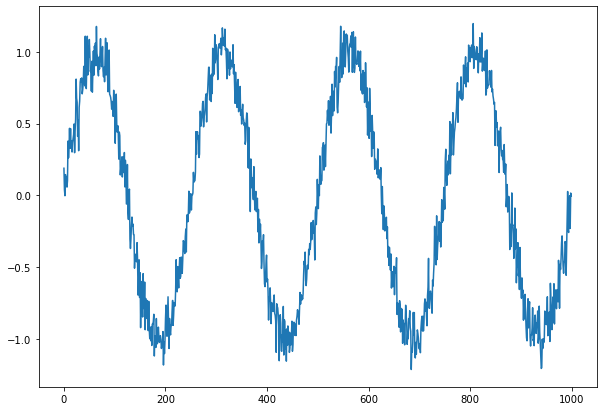

In [13]:
# деление на окна происходит до вызова TrendClassification
n = 1000
p = 4
seq = np.sin(np.linspace(-p*np.pi,p*np.pi,n)) + whiteNoise(sigma=0.1,size=n)

plt.figure(figsize=(10,7))
plt.plot(seq)

In [14]:
seq_main = seq
seq_main_df = pd.DataFrame(seq_main, columns=['value'])

# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

windows, windows_future = split_on_windows(seq_main_df,len_w,len_w_future,step=step)
windows_future_train, windows_future_test = train_test_split(windows_future, test_size=0.33, shuffle=False) 

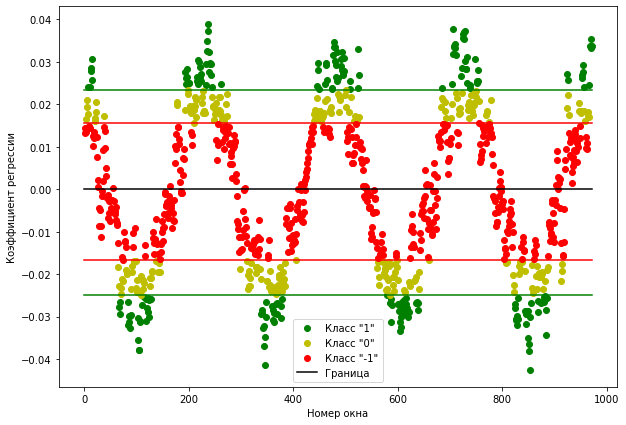

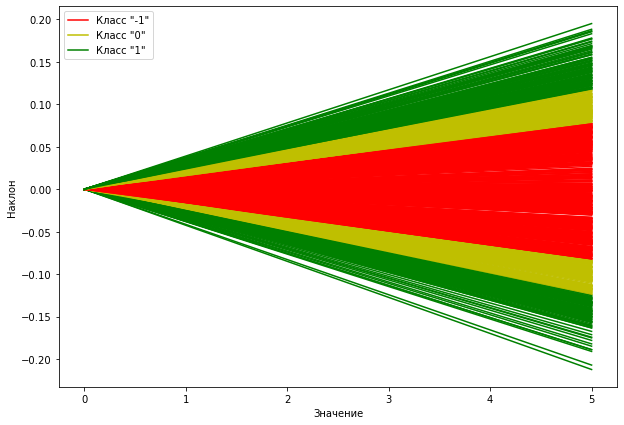

In [15]:
# Получаем классы
gc = GetClasses(method='growth')
gc_classes = gc.get_classes(windows_future_train, windows_future_test)
gc.plot()

gc.plot_coefs()

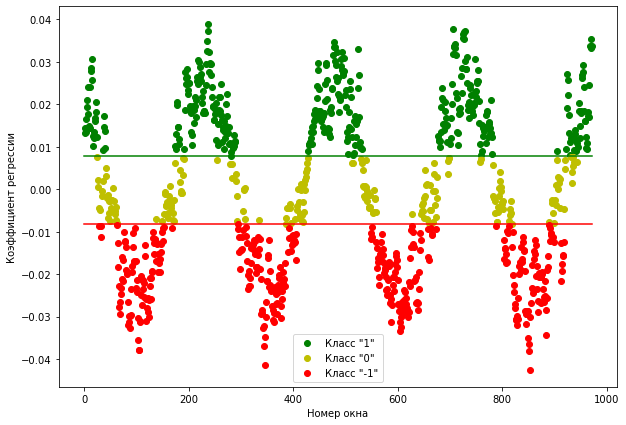

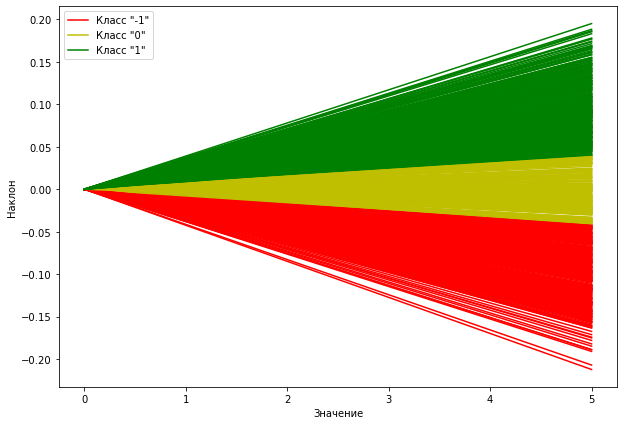

In [16]:
tc = GetClasses(method='type')
tc_classes = tc.get_classes(windows_future_train, windows_future_test)
tc.plot()
tc.plot_coefs()

In [ ]:
random_state = 42
features_mss = 'mean_std_slope'
features_rocket = 'rocket'
max_depth = 3

In [39]:
# Разбиение на обучающую и тренировочную выборку
gc_X_train, gc_X_test, gc_y_train, gc_y_test = train_test_split(windows, gc_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification (mean_std_slope)
gc_mss = TrendClassification(max_depth=max_depth,features=features_mss,random_state=random_state)
gc_mss.fit(gc_X_train,gc_y_train)
print('Trend Classification (features=mean_std_slope,method=growth)',gc_mss.score(gc_X_test,gc_y_test))

# Trend Classification (rocket)
gc_rocket = TrendClassification(max_depth=max_depth,features=features_rocket,random_state=random_state)
gc_rocket.fit(gc_X_train,gc_y_train)
print('Trend Classification (features=rocket,method=growth)',gc_rocket.score(gc_X_test,gc_y_test))


Trend Classification (features=mean_std_slope,method=growth) 0.5171339563862928
Trend Classification (features=rocket,method=growth) 0.5202492211838006


In [40]:
# Разбиение на обучающую и тренировочную выборку
tc_X_train, tc_X_test, tc_y_train, tc_y_test = train_test_split(windows, tc_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification (mean_std_slope)
tc_mss = TrendClassification(max_depth=max_depth,features=features_mss,random_state=random_state)
tc_mss.fit(tc_X_train,tc_y_train)
print('Trend Classification (features=mean_std_slope,method=type)',tc_mss.score(tc_X_test,tc_y_test))

# Trend Classification (rocket)
tc_rocket = TrendClassification(max_depth=max_depth,features=features_rocket,random_state=random_state)
tc_rocket.fit(tc_X_train,tc_y_train)
print('Trend Classification (features=rocket,method=type)',tc_rocket.score(tc_X_test,tc_y_test))



Trend Classification (features=mean_std_slope,method=type) 0.3894080996884735
Trend Classification (features=rocket,method=type) 0.37694704049844235


### Реальные данные

In [72]:
yahoo_stock = pd.read_csv('datasets\Time Series Forecasting with Yahoo Stock Price\yahoo_stock.csv')
yahoo_stock['Date'] = pd.to_datetime(yahoo_stock['Date'])
yahoo_stock.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [73]:
yahoo_stock_high = yahoo_stock[['Date','High']]
yahoo_stock_high.head()

,Date,High
0,2015-11-23,2095.610107
1,2015-11-24,2094.120117
2,2015-11-25,2093.000000
3,2015-11-26,2093.000000
4,2015-11-27,2093.290039


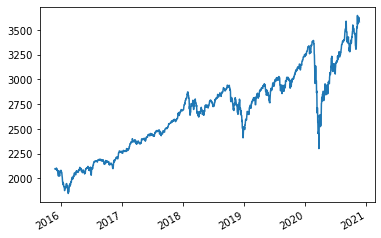

In [74]:
plt.plot(yahoo_stock_high['Date'], yahoo_stock_high['High'])
plt.gcf().autofmt_xdate()

In [75]:
high = yahoo_stock_high['High']

In [76]:
# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

high_windows, high_windows_future = split_on_windows(high,len_w,len_w_future,step=step)

In [77]:
high_windows_future_train, high_windows_future_test = train_test_split(high_windows_future, test_size=0.33, shuffle=False) 

In [79]:
# Получаем классы
high_gc = GetClasses(method='growth')
high_gc_classes = high_gc.get_classes(high_windows_future_train, high_windows_future_test)

high_tc = GetClasses(method='type')
high_tc_classes = high_tc.get_classes(high_windows_future_train, high_windows_future_test)

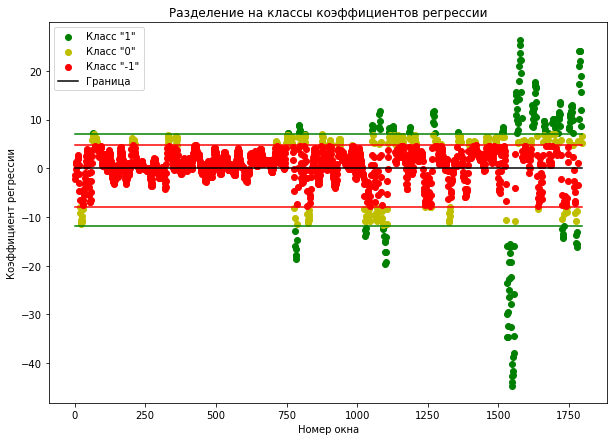

In [80]:
high_gc.plot()

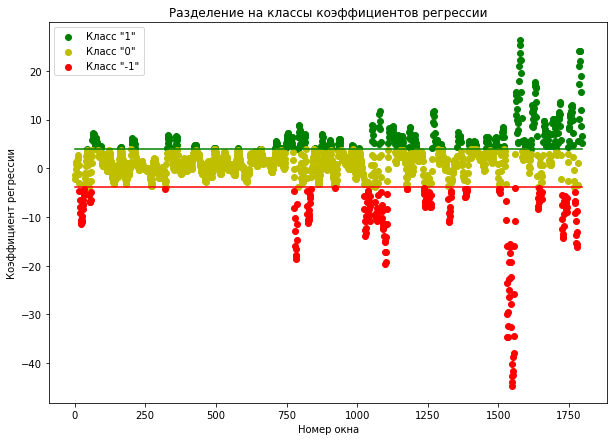

In [81]:
high_tc.plot()

In [82]:
# Устанавливаем параметры
random_state = 42
features_mss = 'mean_std_slope'
features_rocket = 'rocket'
max_depth = 3

In [83]:
# Разбиение на обучающую и тренировочную выборку
X_train, X_test, y_train, y_test = train_test_split(high_windows, high_gc_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification (mean_std_slope)
high_gc_mss = TrendClassification(max_depth=max_depth,features=features_mss,random_state=random_state)
high_gc_mss.fit(X_train,y_train)
print('Trend Classification (features=mean_std_slope,method=growth)',high_gc_mss.score(X_test,y_test))

# Trend Classification (rocket)
high_gc_rocket = TrendClassification(max_depth=max_depth,features=features_rocket,random_state=random_state)
high_gc_rocket.fit(X_train,y_train)
print('Trend Classification (features=rocket,method=growth)',high_gc_rocket.score(X_test,y_test))


Trend Classification (features=mean_std_slope,method=growth) 0.5564924114671164
Trend Classification (features=rocket,method=growth) 0.5666104553119731


In [84]:
# Разбиение на обучающую и тренировочную выборку
X_train, X_test, y_train, y_test = train_test_split(high_windows, high_tc_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification (mean_std_slope)
high_tc_mss = TrendClassification(max_depth=max_depth,features=features_mss,random_state=random_state)
high_tc_mss.fit(X_train,y_train)
print('Trend Classification (features=mean_std_slope,method=type)',high_tc_mss.score(X_test,y_test))

# Trend Classification (rocket)
high_tc_rocket = TrendClassification(max_depth=max_depth,features=features_rocket,random_state=random_state)
high_tc_rocket.fit(X_train,y_train)
print('Trend Classification (features=rocket,method=type)',high_tc_rocket.score(X_test,y_test))



Trend Classification (features=mean_std_slope,method=type) 0.4300168634064081
Trend Classification (features=rocket,method=type) 0.3608768971332209


## Сравнение методов классификации

In [87]:
# Сравнение с другими методами классификации
from sklearn import svm # Support Vector Machines
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent - Стохастичяеский градиентный спуск
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bayes
from sklearn.neural_network import MLPClassifier # Neural network models
from pyts.classification import TimeSeriesForest # Time Series Forest
from pyts.classification import TSBF # Time Series Bag-of-Features

In [238]:
def get_scores_models(X_train,X_test,y_train,y_test,method):
    scores = []
    
    if method in ('mean_std_slope', 'rocket'):
        scores.append(None)
        scores.append(None)
    else:
        # TimeSeriesForest
        tsf = TimeSeriesForest()
        tsf.fit(X_train,y_train)
        scores.append(tsf.score(X_test,y_test))

        # Time Series Bag-of-Features
        tsbf = TSBF(random_state=43, bins=5)
        tsbf.fit(X_train,y_train)
        scores.append(tsbf.score(X_test,y_test))

    # Support Vector Machines(rbf)
    svc = svm.SVC(kernel='rbf')
    svc.fit(X_train, y_train)
    scores.append(svc.score(X_test,y_test))
    
    # Support Vector Machines(linear)
    svc = svm.SVC(kernel='linear')
    svc.fit(X_train, y_train)
    scores.append(svc.score(X_test,y_test))
    
    # Support Vector Machines(poly)
    svc = svm.SVC(kernel='poly')
    svc.fit(X_train, y_train)
    scores.append(svc.score(X_test,y_test))

    # Stochastic Gradient Descent(log_loss)
    sgdc = SGDClassifier(loss="log", penalty="l2", max_iter=5)
    sgdc.fit(X_train, y_train)
    scores.append(sgdc.score(X_test,y_test))
    
    # Stochastic Gradient Descent(squared_hinge)
    sgdc = SGDClassifier(loss="squared_hinge", penalty="l2", max_iter=5)
    sgdc.fit(X_train, y_train)
    scores.append(sgdc.score(X_test,y_test))

    return scores

def get_scores(X,y,method,**kwargs):
    score = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False, random_state=kwargs['random_state'])
    
    # Trend Classification 
    tc = TrendClassification(features=method,random_state=kwargs['random_state'])
    tc.fit(X_train,y_train)
    score.append(tc.score(X_test,y_test))
    
    if method == 'mean_std_slope':
        X = extract_mean_std_slope(X)
    elif method == 'rocket':
        X = extract_rocket(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False, random_state=kwargs['random_state'])
    
    # Другие модели
    score += get_scores_models(X_train, X_test, y_train, y_test,method)
    return score

In [239]:
# Устанавливаем параметры
random_state = 42
features_none = None
features_mss = 'mean_std_slope'
features_rocket = 'rocket'
max_depth = 3

### Искусственные данные

In [240]:
# деление на окна происходит до вызова TrendClassification
n = 1000
p = 4
test_synthetic = np.sin(np.linspace(-p*np.pi,p*np.pi,n)) + whiteNoise(sigma=0.1,size=n)

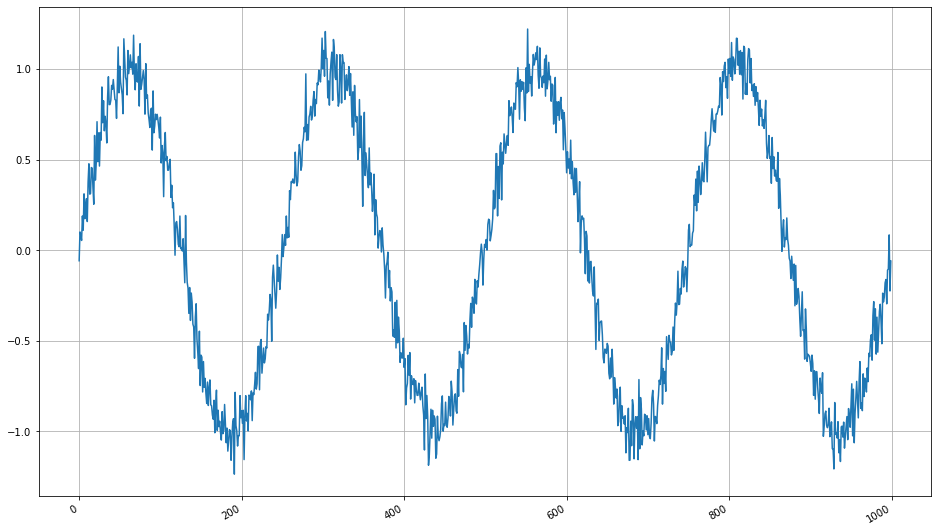

In [241]:
plt.figure(figsize=(16,10))
plt.plot(test_synthetic)
plt.gcf().autofmt_xdate()
plt.grid()

In [242]:
# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

windows_synthetic, windows_future_synthetic = split_on_windows(test_synthetic,len_w,len_w_future,step=step)

windows_future_synthetic_train, windows_future_synthetic_test = train_test_split(windows_future_synthetic, test_size=0.33, shuffle=False) 

In [243]:
# Получаем классы
gc_synthetic = GetClasses(method='growth')
gc_synthetic_classes = gc_synthetic.get_classes(windows_future_synthetic_train, windows_future_synthetic_test)

tc_synthetic = GetClasses(method='type')
tc_synthetic_classes = tc_synthetic.get_classes(windows_future_synthetic_train, windows_future_synthetic_test)

scores_synthetic = pd.DataFrame(['Trend Classification',
                                 'Time Series Forest',
                                 'Time Series Bag-of-Features',
                                 'Support Vector Machines (rbf)',
                                 'Support Vector Machines (linear)',
                                 'Support Vector Machines (poly)',         
                                 'Stochastic Gradient Descent (log_loss)',
                                 'Stochastic Gradient Descent (squared_hinge)'
                                ],
                                columns=['Классификатор'])

#### Метод разделения growth

In [244]:
# Грубая выборка
scores_synthetic['Грубые (степень изменения)'] = get_scores(windows_synthetic,gc_synthetic_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_synthetic['Среднее, отклонение, наклон (степень изменения)'] = get_scores(windows_synthetic,gc_synthetic_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_synthetic['ROCKET (степень изменения)'] = get_scores(windows_synthetic,gc_synthetic_classes,method='rocket',random_state=random_state)

#### Метод разделения type

In [245]:
# Грубая выборка
scores_synthetic['Грубые (направление)'] = get_scores(windows_synthetic,tc_synthetic_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_synthetic['Среднее, отклонение, наклон(направление)'] = get_scores(windows_synthetic,tc_synthetic_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_synthetic['ROCKET (направление)'] = get_scores(windows_synthetic,tc_synthetic_classes,method='rocket',random_state=random_state)

In [246]:
scores_synthetic

,Классификатор,Грубые (степень изменения),"Среднее, отклонение, наклон (степень изменения)",ROCKET (степень изменения),Грубые (направление),"Среднее, отклонение, наклон(направление)",ROCKET (направление)
0,Trend Classification,0.638629,0.610592,0.657321,0.841121,0.760125,0.819315
1,Time Series Forest,0.672897,NaN,NaN,0.853583,NaN,NaN
2,Time Series Bag-of-Features,0.610592,NaN,NaN,0.747664,NaN,NaN
3,Support Vector Machines (rbf),0.591900,0.548287,0.591900,0.862928,0.641745,0.853583
4,Support Vector Machines (linear),0.448598,0.448598,0.626168,0.809969,0.604361,0.803738
5,Support Vector Machines (poly),0.448598,0.526480,0.641745,0.744548,0.588785,0.834891
6,Stochastic Gradient Descent (log_loss),0.426791,0.423676,0.554517,0.697819,0.676012,0.797508
7,Stochastic Gradient Descent (squared_hinge),0.330218,0.436137,0.573209,0.757009,0.417445,0.760125


#### Матрица ошибок

In [289]:
# growth None
X_train, X_test, y_train, y_test = train_test_split(windows_synthetic, gc_synthetic_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification 
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[126  10   8]
 [ 45  30  28]
 [ 12  13  49]]


In [247]:
# growth mss
X_train, X_test, y_train, y_test = train_test_split(windows_synthetic, gc_synthetic_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification 
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[123  12   9]
 [ 38  29  36]
 [ 10  20  44]]


In [248]:
# growth rocket
X_train, X_test, y_train, y_test = train_test_split(windows_synthetic, gc_synthetic_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification 
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=10000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[129  10   5]
 [ 37  36  30]
 [ 16  18  40]]


In [290]:
# type None
X_train, X_test, y_train, y_test = train_test_split(windows_synthetic, tc_synthetic_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification 
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[ 96  10   1]
 [  5  38  21]
 [  0  14 136]]


In [249]:
# type mss
X_train, X_test, y_train, y_test = train_test_split(windows_synthetic, tc_synthetic_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification 
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[ 92  14   1]
 [ 10  28  26]
 [  1  25 124]]


In [250]:
# type rocket
X_train, X_test, y_train, y_test = train_test_split(windows_synthetic, tc_synthetic_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification 
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=10000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[ 98   8   1]
 [  7  38  19]
 [  0  17 133]]


### Yahoo Stock Price

In [252]:
yahoo_stock = pd.read_csv('datasets\Time Series Forecasting with Yahoo Stock Price\yahoo_stock.csv')
yahoo_stock['Date'] = pd.to_datetime(yahoo_stock['Date'])
yahoo_stock.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [253]:
yahoo_stock_high = yahoo_stock[['Date','High']]

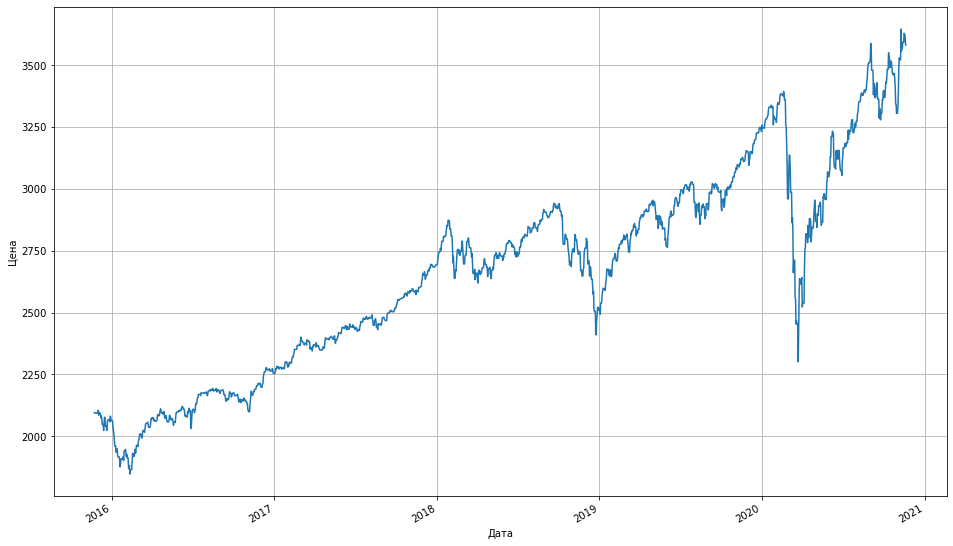

In [254]:
plt.figure(figsize=(16,10))
plt.plot(yahoo_stock_high['Date'], yahoo_stock_high['High'])
plt.gcf().autofmt_xdate()
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid()

In [255]:
high = yahoo_stock_high['High']

In [256]:
# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

windows_real, windows_future_real = split_on_windows(high,len_w,len_w_future,step=step)

In [257]:
windows_future_real_train, windows_future_real_test = train_test_split(windows_future_real, test_size=0.33, shuffle=False) 

In [258]:
# Получаем классы
gc_real = GetClasses(method='growth')
gc_real_classes = gc_real.get_classes(windows_future_real_train, windows_future_real_test)

tc_real = GetClasses(method='type')
tc_real_classes = tc_real.get_classes(windows_future_real_train, windows_future_real_test)

scores_real = pd.DataFrame(['Trend Classification',
                            'Time Series Forest',
                            'Time Series Bag-of-Features',
                            'Support Vector Machines (rbf)',
                            'Support Vector Machines (linear)',
                            'Support Vector Machines (poly)', 
                            'Stochastic Gradient Descent (log_loss)',
                            'Stochastic Gradient Descent (squared_hinge)'
                            ],
                           columns=['Классификатор'])

#### Метод разделения growth

In [259]:
# Грубая выборка
scores_real['Грубые (степень изменения)'] = get_scores(windows_real,gc_real_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_real['Среднее, отклонение, наклон (степень изменения)'] = get_scores(windows_real,gc_real_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_real['ROCKET (степень изменения)'] = get_scores(windows_real,gc_real_classes,method='rocket',random_state=random_state)

#### Метод разделения type

In [260]:
# Грубая выборка
scores_real['Грубые (направление)'] = get_scores(windows_real,tc_real_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_real['Среднее, отклонение, наклон (направление)'] = get_scores(windows_real,tc_real_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_real['ROCKET (направление)'] = get_scores(windows_real,tc_real_classes,method='rocket',random_state=random_state)

In [261]:
scores_real

,Классификатор,Грубые (степень изменения),"Среднее, отклонение, наклон (степень изменения)",ROCKET (степень изменения),Грубые (направление),"Среднее, отклонение, наклон (направление)",ROCKET (направление)
0,Trend Classification,0.283305,0.382799,0.389545,0.330523,0.254637,0.268128
1,Time Series Forest,0.347386,NaN,NaN,0.274874,NaN,NaN
2,Time Series Bag-of-Features,0.284992,NaN,NaN,0.268128,NaN,NaN
3,Support Vector Machines (rbf),0.569983,0.569983,0.569983,0.350759,0.276560,0.276560
4,Support Vector Machines (linear),0.588533,0.583474,0.499157,0.376054,0.462057,0.377740
5,Support Vector Machines (poly),0.571669,0.569983,0.569983,0.362563,0.276560,0.276560
6,Stochastic Gradient Descent (log_loss),0.569983,0.569983,0.569983,0.276560,0.276560,0.527825
7,Stochastic Gradient Descent (squared_hinge),0.258010,0.188870,0.569983,0.527825,0.276560,0.276560


#### Матрица ошибок

In [291]:
X_train, X_test, y_train, y_test = train_test_split(windows_real, gc_real_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [292]:
# growth None
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[ 81 233  24]
 [ 28  77   7]
 [ 20 113  10]]


In [263]:
# growth mss
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[146 100  92]
 [ 40  39  33]
 [ 42  59  42]]


In [264]:
# growth rocket
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=10000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[188 102  48]
 [ 55  47  10]
 [ 49  64  30]]


In [293]:
X_train, X_test, y_train, y_test = train_test_split(windows_real, tc_real_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [294]:
# type None
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[113   3   0]
 [127  31   6]
 [221  40  52]]


In [266]:
# type mss
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[ 97   2  17]
 [147  10   7]
 [249  20  44]]


In [267]:
# type rocket
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=10000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[104  12   0]
 [130  33   1]
 [247  48  18]]


In [288]:
X = extract_mean_std_slope(windows_real)
X_train, X_test, y_train, y_test = train_test_split(X, gc_real_classes, test_size=0.33, shuffle=False, random_state=random_state)

svc = svm.SVC(kernel='poly')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test,y_pred))


[[338   0   0]
 [112   0   0]
 [143   0   0]]


### EUR/USD

In [268]:
def convert_cost(x):
    res = int(x[:-5])
    res += int(x[-4:])/10000
    return res

In [269]:
eur_usd_main = pd.read_csv('datasets\EUR_USD.csv')

In [270]:
eur_usd_main['Дата'] = pd.to_datetime(eur_usd_main['Дата'],format='%d.%m.%Y')
eur_usd_main['Цена'] = eur_usd_main['Цена'].apply(convert_cost)

In [271]:
eur_usd_main

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
0,2023-06-08,1.0779,"1,0707","1,0787","1,0701",NaN,"0,67%"
1,2023-06-07,1.0707,"1,0699","1,0739","1,0669",NaN,"0,15%"
2,2023-06-06,1.0691,"1,0714","1,0733","1,0667",NaN,"-0,20%"
3,2023-06-05,1.0712,"1,0712","1,0724","1,0674",NaN,"0,06%"
4,2023-06-02,1.0706,"1,0762","1,0780","1,0704",NaN,"-0,51%"
...,...,...,...,...,...,...,...
3500,2010-01-07,1.4318,"1,4407","1,4447","1,4295",NaN,"-0,66%"
3501,2010-01-06,1.4413,"1,4364","1,4436","1,4282",NaN,"0,31%"
3502,2010-01-05,1.4369,"1,4409","1,4484","1,4346",NaN,"-0,31%"
3503,2010-01-04,1.4413,"1,4325","1,4457","1,4257",NaN,"0,61%"


In [272]:
eur_usd = eur_usd_main[['Дата','Цена']]

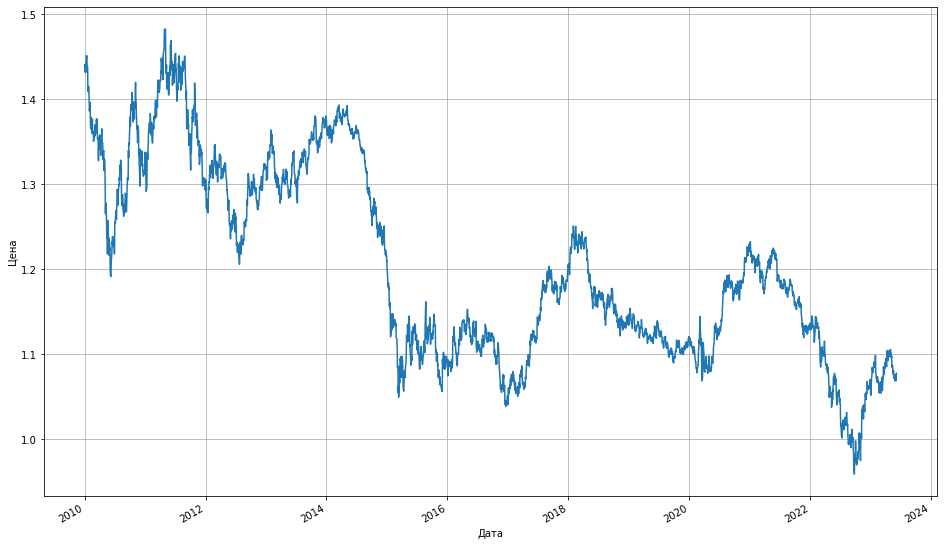

In [273]:
plt.figure(figsize=(16,10))
plt.plot(eur_usd['Дата'], eur_usd['Цена'])
plt.gcf().autofmt_xdate()
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid()

In [274]:
cost = eur_usd['Цена']

In [275]:
# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

windows_cost, windows_future_cost = split_on_windows(cost,len_w,len_w_future,step=step)
windows_future_cost_train, windows_future_cost_test = train_test_split(windows_future_cost, test_size=0.33, shuffle=False) 

In [276]:
# Получаем классы
gc_cost = GetClasses(method='growth',percent=25)
gc_cost_classes = gc_cost.get_classes(windows_future_cost_train, windows_future_cost_test)

tc_cost = GetClasses(method='type')
tc_cost_classes = tc_cost.get_classes(windows_future_cost_train, windows_future_cost_test)

scores_eur_usd = pd.DataFrame(['Trend Classification',
                                'Time Series Forest',
                                'Time Series Bag-of-Features',
                                'Support Vector Machines (rbf)',
                                'Support Vector Machines (linear)',
                                'Support Vector Machines (poly)', 
                                'Stochastic Gradient Descent (log_loss)',
                                'Stochastic Gradient Descent (squared_hinge)',
                                ],
                               columns=['Классификатор'])

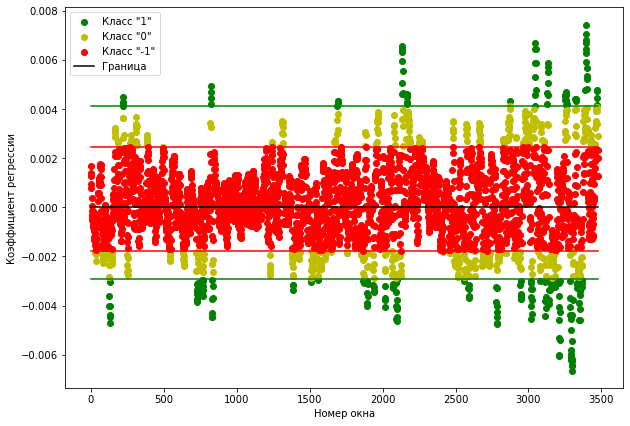

In [277]:
gc_cost.plot()

#### Метод разделения growth

In [278]:
# Грубая выборка
scores_eur_usd['Грубые (степень изменения)'] = get_scores(windows_cost,gc_cost_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_eur_usd['Среднее, отклонение, наклон (степень изменения)'] = get_scores(windows_cost,gc_cost_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_eur_usd['ROCKET (степень изменения)'] = get_scores(windows_cost,gc_cost_classes,method='rocket',random_state=random_state)

#### Метод разделения type

In [279]:
# Грубая выборка
scores_eur_usd['Грубые (направление)'] = get_scores(windows_cost,tc_cost_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_eur_usd['Среднее, отклонение, наклон (направление)'] = get_scores(windows_cost,tc_cost_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_eur_usd['ROCKET (направление)'] = get_scores(windows_cost,tc_cost_classes,method='rocket',random_state=random_state)

In [280]:
scores_eur_usd

,Классификатор,Грубые (степень изменения),"Среднее, отклонение, наклон (степень изменения)",ROCKET (степень изменения),Грубые (направление),"Среднее, отклонение, наклон (направление)",ROCKET (направление)
0,Trend Classification,0.644599,0.621080,0.628049,0.351916,0.364111,0.402439
1,Time Series Forest,0.639373,NaN,NaN,0.386760,NaN,NaN
2,Time Series Bag-of-Features,0.610627,NaN,NaN,0.361498,NaN,NaN
3,Support Vector Machines (rbf),0.647213,0.647213,0.647213,0.360627,0.374564,0.374564
4,Support Vector Machines (linear),0.647213,0.647213,0.647213,0.374564,0.374564,0.374564
5,Support Vector Machines (poly),0.647213,0.647213,0.647213,0.371080,0.374564,0.374564
6,Stochastic Gradient Descent (log_loss),0.647213,0.647213,0.647213,0.374564,0.374564,0.374564
7,Stochastic Gradient Descent (squared_hinge),0.647213,0.647213,0.647213,0.328397,0.402439,0.374564


#### Матрица ошибок

In [295]:
X_train, X_test, y_train, y_test = train_test_split(windows_cost, gc_cost_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [296]:
# growth None
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[732  11   0]
 [262   8   0]
 [134   1   0]]


In [282]:
# growth mss
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[701  42   0]
 [258  12   0]
 [129   6   0]]


In [283]:
# growth rocket
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=10000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[694  47   2]
 [244  26   0]
 [106  29   0]]


In [297]:
X_train, X_test, y_train, y_test = train_test_split(windows_cost, tc_cost_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [298]:
# type None
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[  0 293  97]
 [  1 302 127]
 [ 22 204 102]]


In [285]:
# type mss
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[ 23 247 120]
 [ 31 275 124]
 [ 40 168 120]]


In [286]:
# type rocket
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=10000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[ 28 217 145]
 [ 41 326  63]
 [ 68 125 135]]


In [287]:
X = extract_mean_std_slope(windows_cost)
X_train, X_test, y_train, y_test = train_test_split(X, gc_cost_classes, test_size=0.33, shuffle=False, random_state=random_state)

svc = svm.SVC(kernel='rbf')
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
confusion_matrix(y_test,y_pred)
np.unique(y_pred)

array([-1])

# ---------------------------------------------------------------------------------------------------------------

# Наилучшие параметры

In [281]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report

In [249]:
# Устанавливаем параметры
random_state = 42
features_none = None
features_mss = 'mean_std_slope'
features_rocket = 'rocket'
max_depth = 3

## Искусственные данные

In [250]:
# деление на окна происходит до вызова TrendClassification
n = 1000
p = 4
seq = np.sin(np.linspace(-p*np.pi,p*np.pi,n)) + whiteNoise(sigma=0.1,size=n)

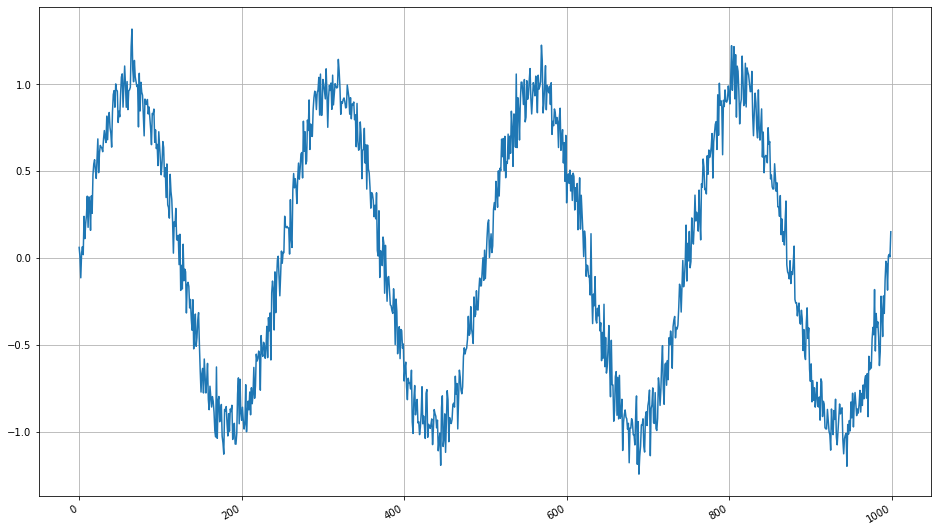

In [251]:
plt.figure(figsize=(16,10))
plt.plot(seq)
plt.gcf().autofmt_xdate()
plt.grid()

In [252]:
# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

windows, windows_future = split_on_windows(seq_main_df,len_w,len_w_future,step=step)
windows_future_train, windows_future_test = train_test_split(windows_future, test_size=0.33, shuffle=False) 

In [253]:
# Получаем классы
gc = GetClasses(method='growth')
gc_classes = gc.get_classes(windows_future_train, windows_future_test)

tc = GetClasses(method='type')
tc_classes = tc.get_classes(windows_future_train, windows_future_test)

In [285]:
# Set the parameters by cross-validation
tuned_parameters = [{
     'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
      'features' : ['mean_std_slope', 'rocket'],
    'n_kernels' : [100, 1000],
    'random_state' : [42]
    }]
tscv = TimeSeriesSplit(n_splits=2)

### growth

In [286]:
X_train, X_test, y_train, y_test = train_test_split(windows, gc_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [287]:
model = GridSearchCV(TrendClassification(), tuned_parameters, cv=tscv)
model.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
best_param_KNN = model.best_params_
print(best_param_KNN)
print()
print("Grid scores on development set:")
print()
means = model.cv_results_["mean_test_score"]
stds = model.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, model.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'criterion': 'gini', 'features': 'rocket', 'max_depth': 7, 'n_estimators': 500, 'n_kernels': 100, 'random_state': 42}

Grid scores on development set:

0.586 (+/-0.116) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.586 (+/-0.116) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 1000, 'random_state': 42}
0.593 (+/-0.120) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 100, 'random_state': 42}
0.593 (+/-0.120) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 1000, 'random_state': 42}
0.586 (+/-0.134) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 5, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.586 (+/-0.134) for {'criterion': 'gini', 'features': 'me

### type

In [288]:
X_train, X_test, y_train, y_test = train_test_split(windows, tc_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [289]:
model = GridSearchCV(TrendClassification(), tuned_parameters, cv=tscv)
model.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
best_param_KNN = model.best_params_
print(best_param_KNN)
print()
print("Grid scores on development set:")
print()
means = model.cv_results_["mean_test_score"]
stds = model.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, model.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'criterion': 'gini', 'features': 'rocket', 'max_depth': 5, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}

Grid scores on development set:

0.766 (+/-0.042) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.766 (+/-0.042) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 1000, 'random_state': 42}
0.769 (+/-0.046) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 100, 'random_state': 42}
0.769 (+/-0.046) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 1000, 'random_state': 42}
0.750 (+/-0.028) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 5, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.750 (+/-0.028) for {'criterion': 'gini', 'features': 'me

## Настоящие данные

In [290]:
yahoo_stock = pd.read_csv('datasets\Time Series Forecasting with Yahoo Stock Price\yahoo_stock.csv')
yahoo_stock['Date'] = pd.to_datetime(yahoo_stock['Date'])
yahoo_stock_high = yahoo_stock[['Date','High']]

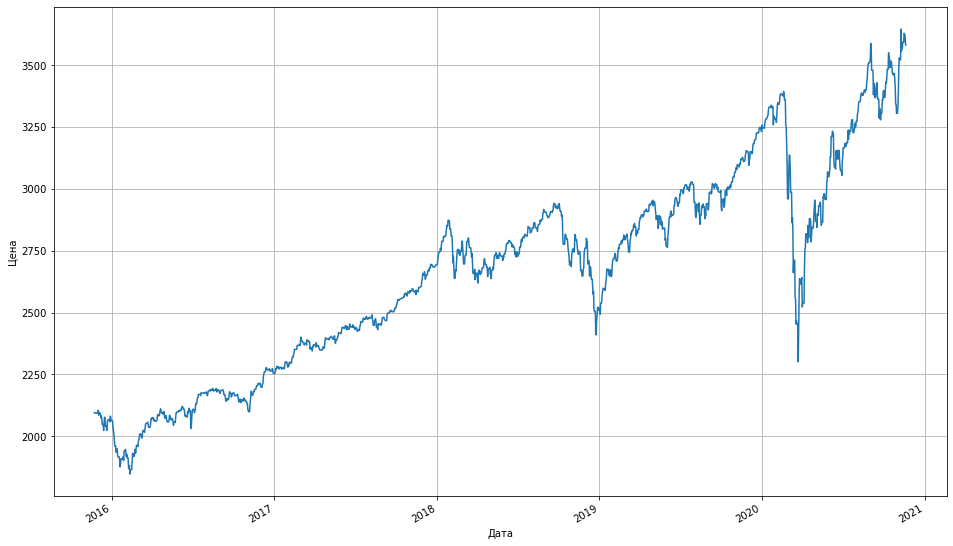

In [291]:
plt.figure(figsize=(16,10))
plt.plot(yahoo_stock_high['Date'], yahoo_stock_high['High'])
plt.gcf().autofmt_xdate()
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid()

In [292]:
high = yahoo_stock_high['High']

In [293]:
# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

windows_real, windows_future_real = split_on_windows(high,len_w,len_w_future,step=step)

In [294]:
windows_future_real_train, windows_future_real_test = train_test_split(windows_future_real, test_size=0.33, shuffle=False) 

In [295]:
# Получаем классы
gc_real = GetClasses(method='growth')
gc_real_classes = gc_real.get_classes(windows_future_real_train, windows_future_real_test)

tc_real = GetClasses(method='type')
tc_real_classes = tc_real.get_classes(windows_future_real_train, windows_future_real_test)

### growth

In [296]:
X_train, X_test, y_train, y_test = train_test_split(windows_real, gc_real_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [297]:
model = GridSearchCV(TrendClassification(), tuned_parameters, cv=tscv)
model.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
best_param_KNN = model.best_params_
print(best_param_KNN)
print()
print("Grid scores on development set:")
print()
means = model.cv_results_["mean_test_score"]
stds = model.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, model.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'criterion': 'entropy', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}

Grid scores on development set:

0.667 (+/-0.426) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.667 (+/-0.426) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 1000, 'random_state': 42}
0.652 (+/-0.456) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 100, 'random_state': 42}
0.652 (+/-0.456) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 1000, 'random_state': 42}
0.665 (+/-0.431) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 5, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.665 (+/-0.431) for {'criterion': 'gini', 'fea

### type

In [298]:
X_train, X_test, y_train, y_test = train_test_split(windows_real, tc_real_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [299]:
model = GridSearchCV(TrendClassification(), tuned_parameters, cv=tscv)
model.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
best_param_KNN = model.best_params_
print(best_param_KNN)
print()
print("Grid scores on development set:")
print()
means = model.cv_results_["mean_test_score"]
stds = model.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, model.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'criterion': 'entropy', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}

Grid scores on development set:

0.519 (+/-0.249) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.519 (+/-0.249) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 1000, 'random_state': 42}
0.520 (+/-0.247) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 100, 'random_state': 42}
0.520 (+/-0.247) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 1000, 'random_state': 42}
0.510 (+/-0.267) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 5, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.510 (+/-0.267) for {'criterion': 'gini', 'fea